# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2 
import os
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
import tqdm.notebook as tq
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Concatenate, Activation, BatchNormalization, Input, GaussianNoise, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

# Load Pickled Data

In [ ]:
def read_images(img_path, gt_path, SHAPE=(256, 192)):
    images = []
    masks = []
    img_dir = sorted(os.listdir(img_path))
    mask_dir = sorted(os.listdir(gt_path))
    for img in tq.tqdm(img_dir):
        path = os.path.join(img_path, img)
        x = plt.imread(path)
        x = cv2.resize(x, SHAPE)
        images.append(x)
    for mask in tq.tqdm(mask_dir):
        path = os.path.join(gt_path, mask)
        x = plt.imread(path)
        x = cv2.resize(x, SHAPE)
        masks.append(x)
    return np.array(images), np.array(masks)

In [ ]:
import pickle
with open('../input/assign4data/data.txt', 'rb') as fh:
    data=pickle.load(fh)
X=data['x_train']
Y=data['y_train']
X_val=data['x_val']
Y_val=data['y_val']
X_test=data['x_test']
Y_test=data['y_test']
print(X.shape, Y.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

# Data generator function

In [ ]:
def make_data_generators(data_gen_args, data, gt, flow_args):
    '''
    Creates the data generators for the pairs of images and the ground truth
     segmentations
    Function will be modified when we get more understanding of the output
    inputs:
        data_gen_args: dictionary to be initialize the ImageDataGenerator object 
        (see ImageDataGenerator Docs to see options)
        data_path: path for a directory that contains the directory of
         the imagesgt_path: path for a directory that contains the directory of 
         the
         ground truths
        flow_args: dict to call the flow or flowectory
         function has
         target_size, batch_size, class_mode, seed, etc. (see ImageDataGenerator
          Docs to see options)
    returns:
        generator: a data generator that has can be passed to a model.fit method 
    '''
    image_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow(data, **flow_args)
    mask_generator = mask_datagen.flow(gt[:, :, :, np.newaxis],
                                       **flow_args)
    
    generator = zip(image_generator, mask_generator)
    
    return generator

# Make Train and Validation Data generators

In [ ]:
data_gen_args = dict(shear_range=0.2,
                     zoom_range=0.2,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1)
flow_from_dir_args = dict(seed=1, batch_size=16, shuffle=True)

In [ ]:
train_generator = make_data_generators(data_gen_args, X, Y, flow_from_dir_args)
val_generator = make_data_generators(dict(), X_val, Y_val, flow_from_dir_args)

# Plot Some Images for observation

In [ ]:
def show_images(images, masks, num_images = 5):
    plt.figure(figsize=(15,25))
    axes_num = 0
    for i in range(num_images):
        plt.subplot(num_images, 2, axes_num+1)
        plt.imshow(images[i])
        plt.title('Original Image')

        plt.subplot(num_images, 2, axes_num+2)
        plt.imshow(np.squeeze(masks[i]), cmap='gray')
        plt.title('Segmentation Mask')
        axes_num += 2

    plt.show()

In [ ]:
temp_data = next(train_generator)

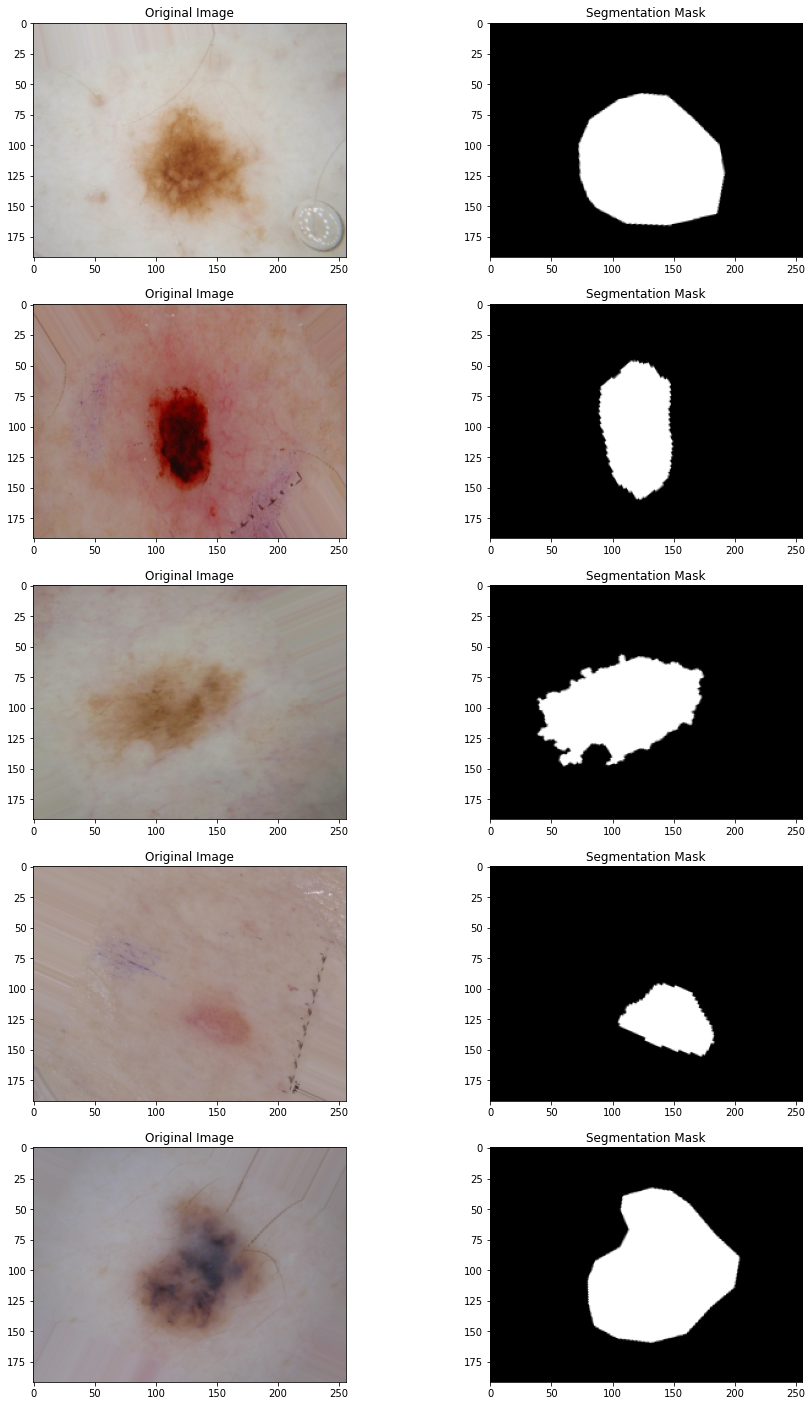

In [ ]:
show_images(temp_data[0], temp_data[1])

# Define Jaccard Coefficient Loss and IOU metric

In [ ]:
def jaccard_loss(y_true, y_pred):
    logits = tf.reshape(y_pred, [-1])
    trn_labels = tf.reshape(y_true, [-1])

    inter = tf.reduce_sum(logits * trn_labels)

    union = tf.reduce_sum((logits + trn_labels) - (logits * trn_labels))

    iou = inter / union
    loss = tf.constant(1.0, dtype=tf.float32) -  iou
    return loss

In [ ]:
def IOU(y_true, y_pred):
    logits = tf.reshape(y_pred, [-1])
    trn_labels = tf.reshape(y_true, [-1])

    inter = tf.reduce_sum(logits * trn_labels)

    union = tf.reduce_sum((logits + trn_labels) - (logits * trn_labels))

    iou = inter/union
    
    return iou

# Loss and metrics visualization function

In [ ]:
def visualize_loss_and_metric(histories):
    fig , ax = plt.subplots(1,2)
    train_iou = train_loss = test_iou = test_loss = []
    for history in histories:
        train_iou = train_iou + history.history['IOU']
        train_loss = train_loss + history.history['loss']
        test_iou = test_iou + history.history['val_IOU']
        test_loss = test_loss + history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(train_loss, label = f'Training Loss')
    ax[0].plot(test_loss , label = f'Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(train_iou, label = f'Training IOU')
    ax[1].plot(test_iou , label = f'Validation IOU')
    ax[1].set_title('Training & Validation IOU')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

# FCN Model (Using VGG-16 as a Backbone)

## FCN Params

In [ ]:
FCN_INP_SHAPE = (192, 256, 3)
FCN_LR = 0.001
FCN_BATCH_SIZE = 16
FCN_EPOCHS = 70

## Define FCN Model

In [ ]:
def make_FCN_model(input_shape = FCN_INP_SHAPE):
    input_img = Input(shape=input_shape)

    model = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(input_img)
    model = Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = MaxPooling2D(pool_size = (2,2))(model)

    model = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = MaxPooling2D(pool_size = (2,2))(model)

    model = Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = MaxPooling2D(pool_size = (2,2))(model)

    model = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = MaxPooling2D(pool_size = (2,2))(model)

    model = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu")(model)
    model = MaxPooling2D(pool_size = (2,2))(model)

    model = Conv2D(filters = 512, kernel_size = (1,1), padding = "same", activation = "relu")(model)
    model = Conv2DTranspose(filters = 1, kernel_size = (64,64), strides = (32,32), padding = "same", use_bias = False)(model)
    model = BatchNormalization()(model)
    model = Conv2D(filters = 1, kernel_size = (1,1), padding = "same", activation = "sigmoid")(model)

    model = Model(input_img, model)
    
    
    optimizer = Adam(learning_rate = FCN_LR)
    model.compile(loss = jaccard_loss, optimizer = optimizer, metrics=[IOU])

    return model

In [ ]:
FCN_model = make_FCN_model()
FCN_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 192, 256, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 192, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 96, 128, 64)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 96, 128, 128)      73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 128, 128)      147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 64, 128)       0   

### Plot Model

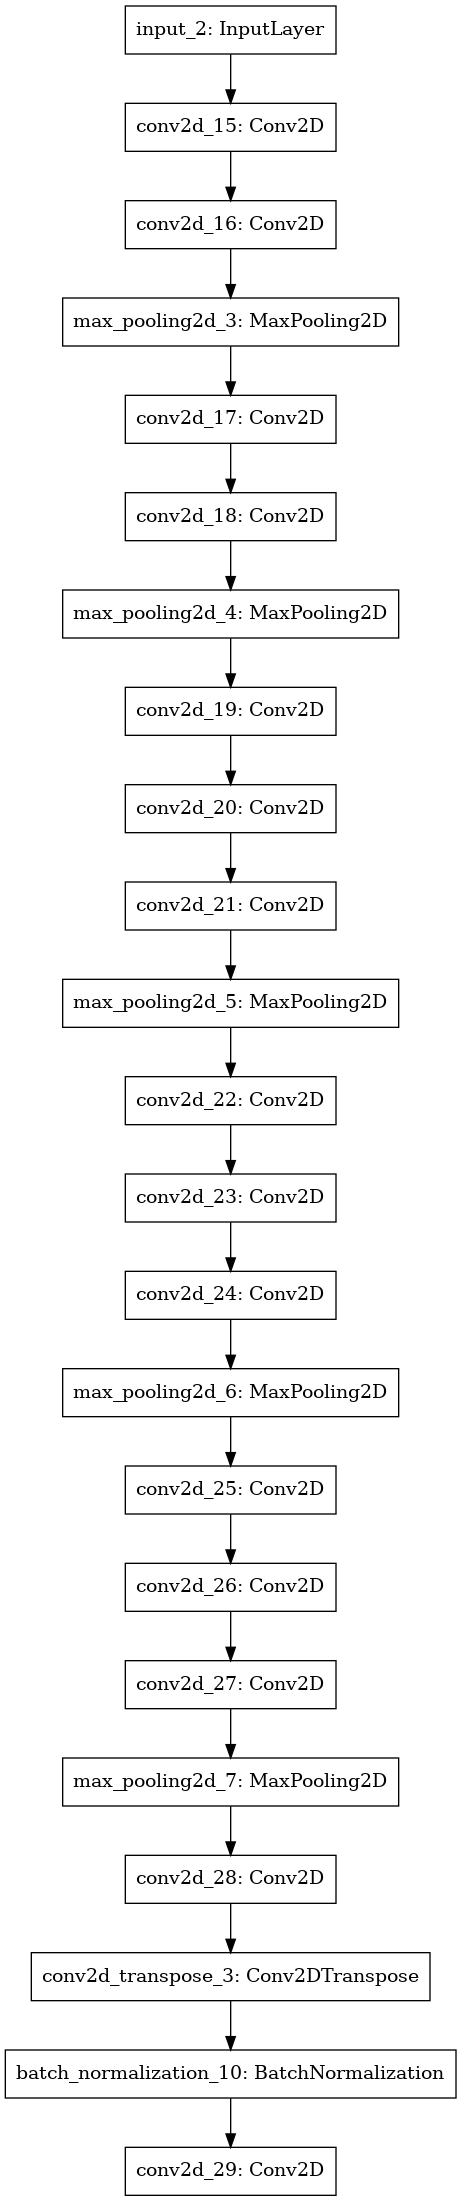

In [ ]:
tf.keras.utils.plot_model(FCN_model)

## Train FCN Model

In [ ]:
steps_per_epoch = 2000 // FCN_BATCH_SIZE
validation_steps = 150 // FCN_BATCH_SIZE

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = FCN_model.fit(train_generator, 
                        epochs = FCN_EPOCHS,
                        validation_data = val_generator,
                        steps_per_epoch = steps_per_epoch,
                        validation_steps = validation_steps,
                        callbacks=[lr_reduce])

2022-01-22 07:51:39.948669: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-01-22 07:51:41.933177: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 41s 253ms/step - loss: 0.7475 - IOU: 0.2525 - val_loss: 0.7556 - val_IOU: 0.2444
Epoch 2/70
125/125 [==============================] - 31s 246ms/step - loss: 0.6946 - IOU: 0.3054 - val_loss: 0.7225 - val_IOU: 0.2775
Epoch 3/70
125/125 [==============================] - 31s 249ms/step - loss: 0.6345 - IOU: 0.3655 - val_loss: 0.6479 - val_IOU: 0.3521
Epoch 4/70
125/125 [==============================] - 31s 250ms/step - loss: 0.5695 - IOU: 0.4305 - val_loss: 0.6190 - val_IOU: 0.3810
Epoch 5/70
125/125 [==============================] - 31s 252ms/step - loss: 0.4961 - IOU: 0.5039 - val_loss: 0.6128 - val_IOU: 0.3872
Epoch 6/70
125/125 [==============================] - 31s 248ms/step - loss: 0.4451 - IOU: 0.5549 - val_loss: 0.5039 - val_IOU: 0.4961
Epoch 7/70
125/125 [==============================] - 31s 250ms/step - loss: 0.4061 - IOU: 0.5939 - val_loss: 0.4536 - val_IOU: 0.5464
Epoch 8/70
125/125 [==============================] - 30s 245ms/st

## FCN Trials

### Model with starting LR = 0.003 for 70 epochs

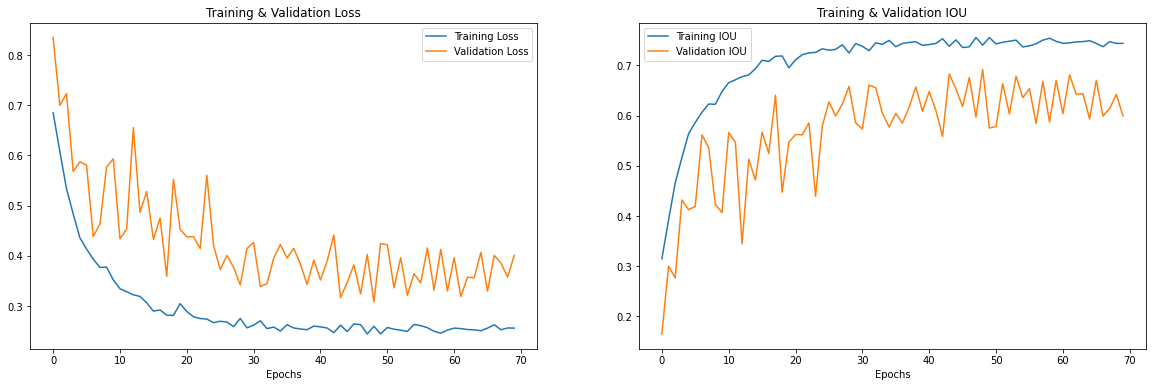

In [ ]:
visualize_loss_and_metric(history)

In [ ]:
out = FCN_model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = FCN_model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 6s 184ms/step - loss: 0.3594 - IOU: 0.6411
jaccard loss = 0.35943299531936646
IOU = 0.6411364674568176


### Model with starting LR = 0.0009 for 70 epochs

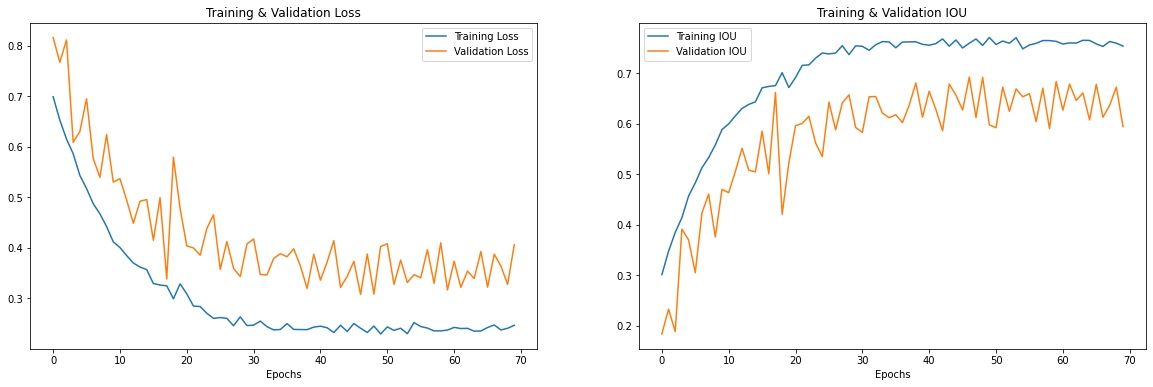

In [ ]:
visualize_loss_and_metric(history)

In [ ]:
out = FCN_model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = FCN_model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 6s 183ms/step - loss: 0.3548 - IOU: 0.6453
jaccard loss = 0.35480231046676636
IOU = 0.6453279256820679


### Model with starting LR = 0.001 for 70 epochs [Best Model]

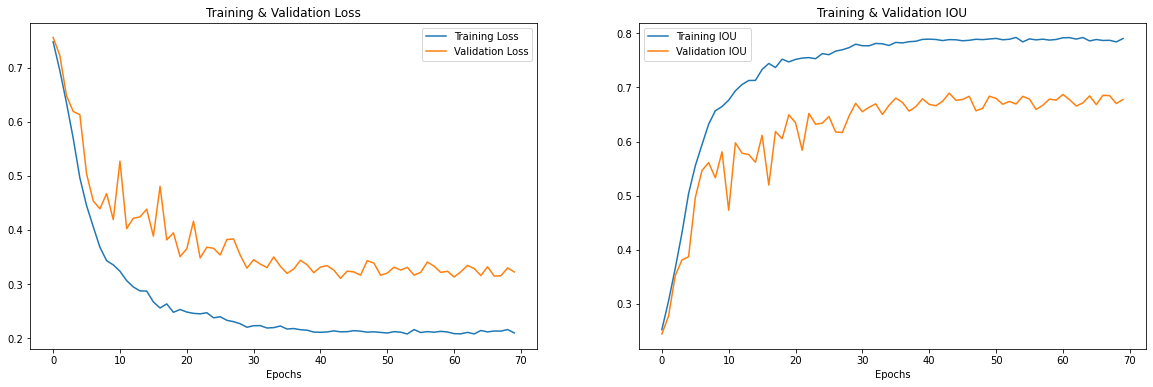

In [ ]:
visualize_loss_and_metric(history)

In [ ]:
out = FCN_model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = FCN_model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 6s 183ms/step - loss: 0.3402 - IOU: 0.6600
jaccard loss = 0.34019824862480164
IOU = 0.6599780917167664


In [ ]:
out[out < 0.5] = 0
out[out >= 0.5] = 1
iou = IOU(Y_test, out)
print(iou)

tf.Tensor(0.6916169, shape=(), dtype=float32)


## Results on test set for best model

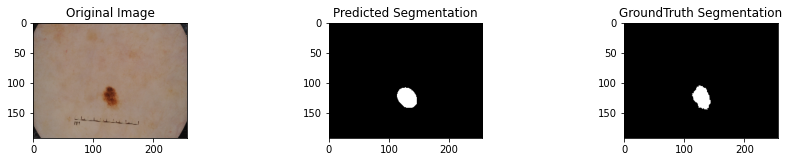

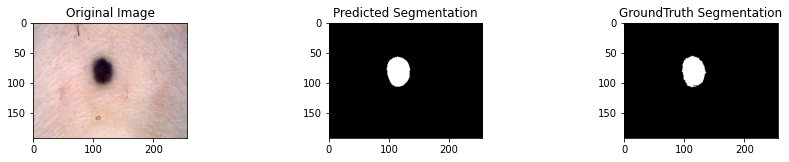

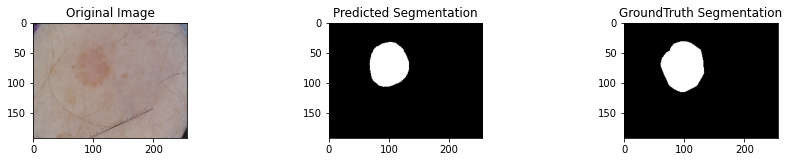

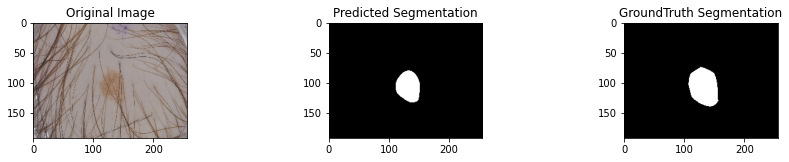

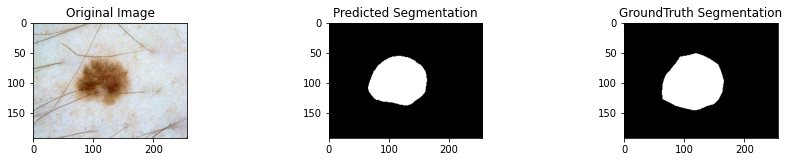

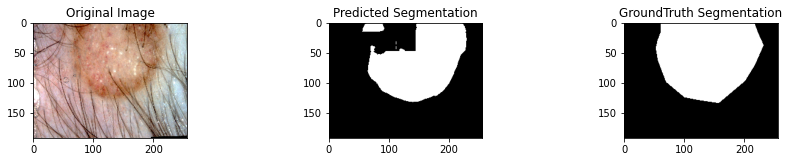

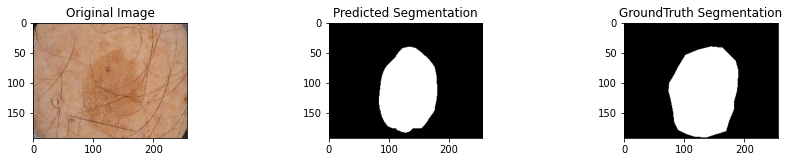

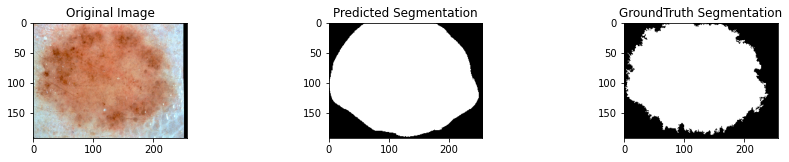

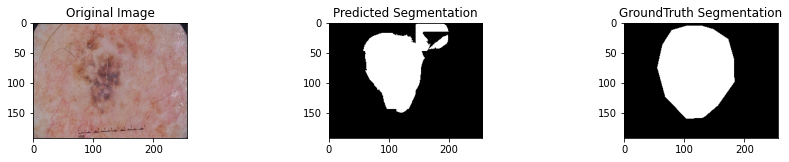

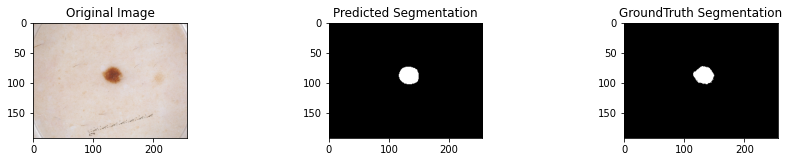

In [ ]:
axes_num = 0
num_images = 10
index_list = np.random.choice(600, 10)
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_test[index_list[i]])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(out[index_list[i]]), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_test[index_list[i]]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

plt.show()

In [ ]:
FCN_model.save_weights('fcn_w.h5')

## Results on validation set for best model

In [ ]:
out = FCN_model.predict(X_val * (1./255), batch_size=16)
out.shape

(150, 192, 256, 1)

In [ ]:
out[out < 0.5] = 0
out[out >= 0.5] = 1
iou = IOU(Y_val, out)
print(iou)

tf.Tensor(0.68091613, shape=(), dtype=float32)


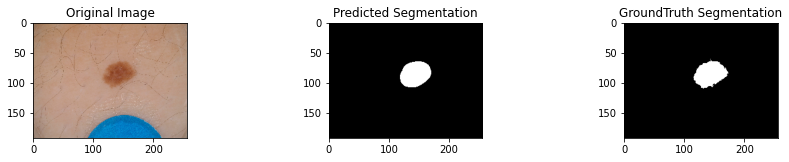

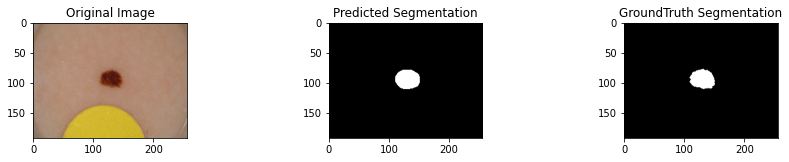

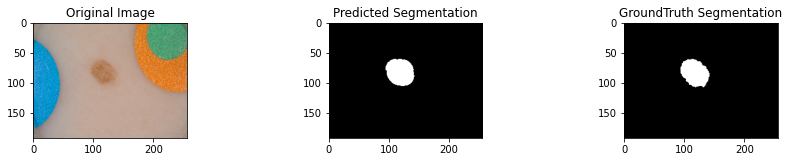

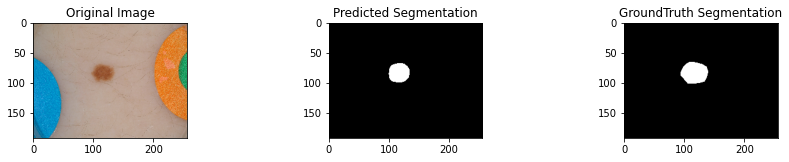

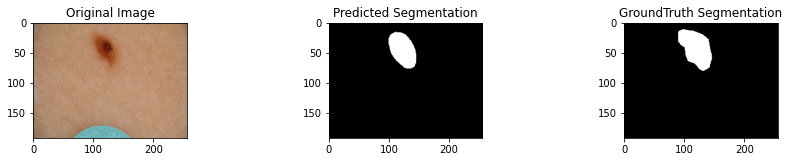

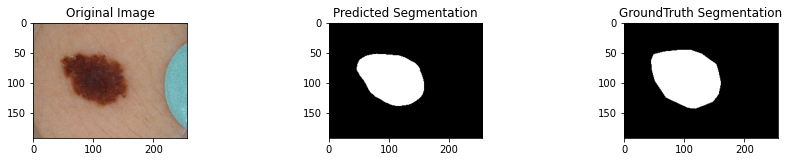

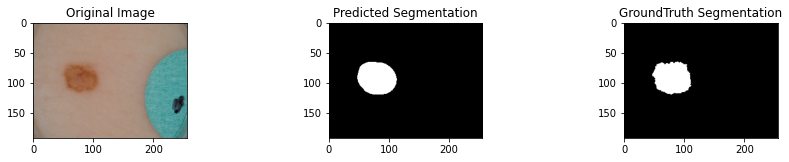

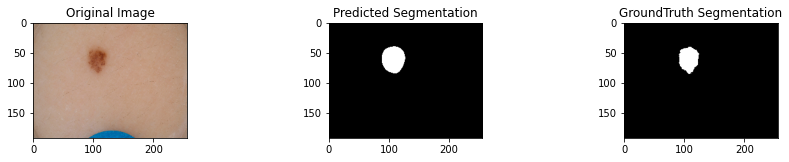

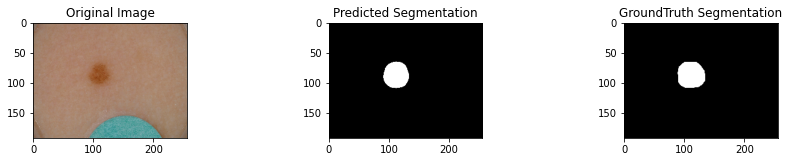

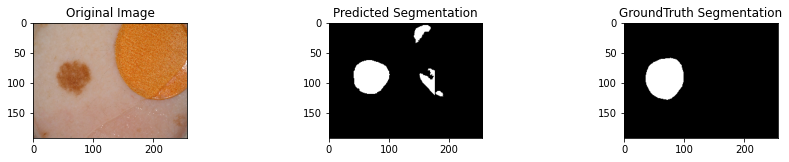

In [ ]:
axes_num = 0
num_images = 10
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_val[i])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(np.squeeze(out[i])), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_val[i]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

    plt.show()

# FCN using VGG16 with imagenet weights
LR = 0.001
Unfreeze the whole model

## Hyperparameters

In [ ]:
FCN_INP_SHAPE = (192, 256, 3)
FCN_LR = 0.001
FCN_BATCH_SIZE = 4
FCN_EPOCHS = 70

## Define Model

In [ ]:
from keras.applications.vgg16 import VGG16

def make_FCN_model(input_shape = FCN_INP_SHAPE):
    input_img = Input(shape=input_shape)

    model = VGG16(include_top=False, weights="imagenet", input_tensor=input_img)
    for layer in model.layers:
        layer.trainable = True
    


    
    model = model.output
    model = Conv2D(filters = 512, kernel_size = (1,1), padding = "same", activation = "relu")(model)
    model = Conv2DTranspose(filters = 1, kernel_size = (64,64), strides = (32,32), padding = "same", use_bias = False)(model)
    model = BatchNormalization()(model)
    model = Conv2D(filters = 1, kernel_size = (1,1), padding = "same", activation = "sigmoid")(model)

    
    model = Model(input_img, model)
    
    optimizer = Adam(learning_rate = FCN_LR)
    model.compile(loss = jaccard_loss, optimizer = optimizer, metrics=[IOU])

    return model

In [ ]:
FCN_model = make_FCN_model()
FCN_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
____________________________________________________________

## Train Model

In [ ]:
steps_per_epoch = 2000 // FCN_BATCH_SIZE
validation_steps = 150 // FCN_BATCH_SIZE

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = FCN_model.fit(train_generator, 
                        epochs = FCN_EPOCHS,
                        validation_data = val_generator,
                        steps_per_epoch = steps_per_epoch,
                        validation_steps = validation_steps,
                        callbacks=[lr_reduce])

2022-01-22 02:24:25.371696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-01-22 02:24:27.958738: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


500/500 [==============================] - 150s 280ms/step - loss: 0.5516 - IOU: 0.4484 - val_loss: 0.5314 - val_IOU: 0.4658
Epoch 2/70
500/500 [==============================] - 140s 281ms/step - loss: 0.3335 - IOU: 0.6665 - val_loss: 0.3887 - val_IOU: 0.6127
Epoch 3/70
500/500 [==============================] - 141s 281ms/step - loss: 0.2678 - IOU: 0.7322 - val_loss: 0.3392 - val_IOU: 0.6517
Epoch 4/70
500/500 [==============================] - 141s 283ms/step - loss: 0.2409 - IOU: 0.7591 - val_loss: 0.3801 - val_IOU: 0.6271
Epoch 5/70
500/500 [==============================] - 142s 283ms/step - loss: 0.2215 - IOU: 0.7785 - val_loss: 0.3489 - val_IOU: 0.6522
Epoch 6/70
500/500 [==============================] - 143s 287ms/step - loss: 0.2089 - IOU: 0.7911 - val_loss: 0.3255 - val_IOU: 0.6705
Epoch 7/70
500/500 [==============================] - 142s 285ms/step - loss: 0.2092 - IOU: 0.7908 - val_loss: 0.3654 - val_IOU: 0.6393
Epoch 8/70
500/500 [==============================] - 145s 

## Evaluate Model

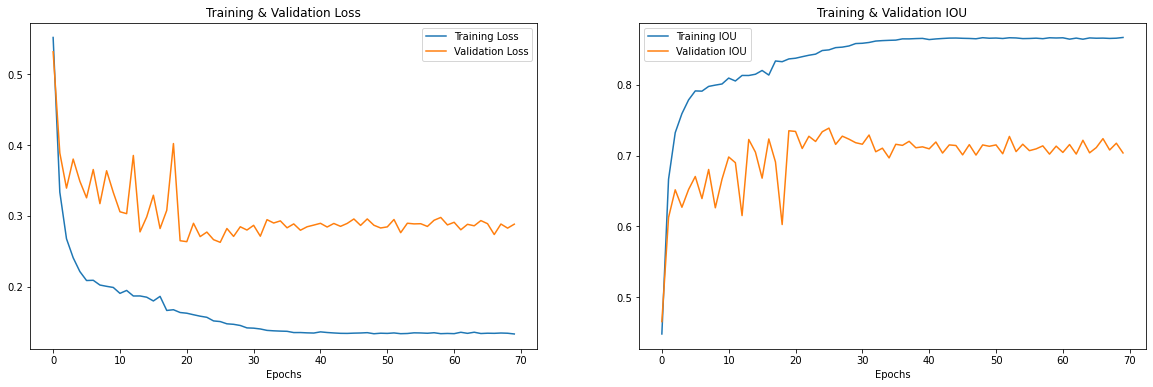

In [ ]:
visualize_loss_and_metric(history)

In [ ]:
out = FCN_model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = FCN_model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 6s 183ms/step - loss: 0.3043 - IOU: 0.6968
jaccard loss = 0.30434879660606384
IOU = 0.6968219876289368


In [ ]:
out[out < 0.5] = 0
out[out >= 0.5] = 1
iou = IOU(Y_test, out)
print(iou)

tf.Tensor(0.71642876, shape=(), dtype=float32)


## Results on test set

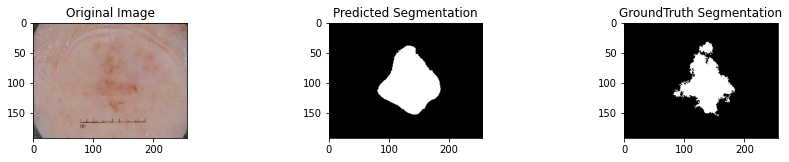

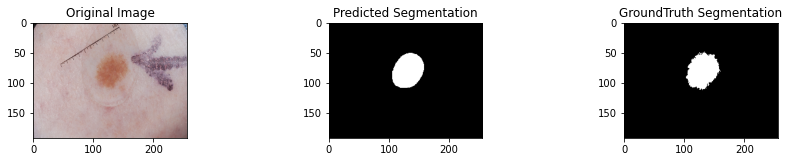

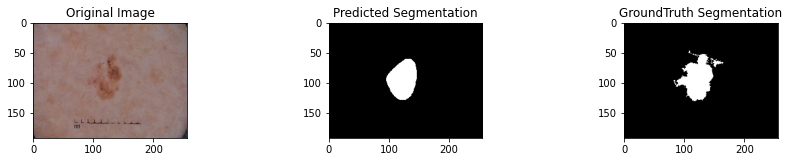

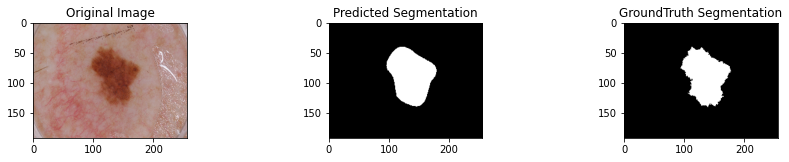

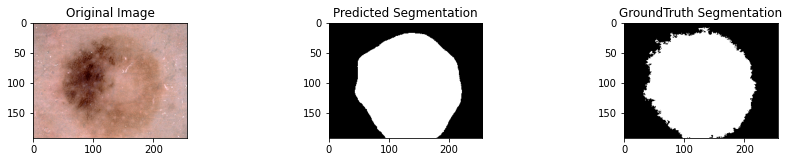

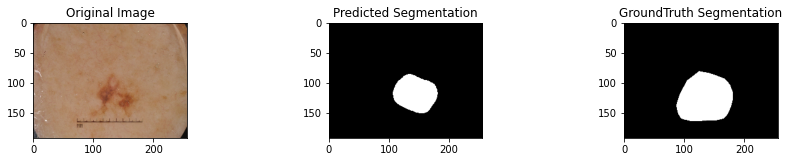

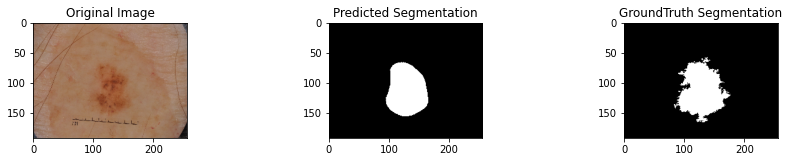

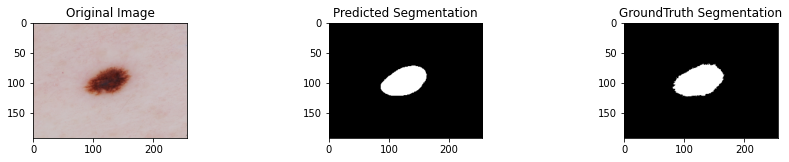

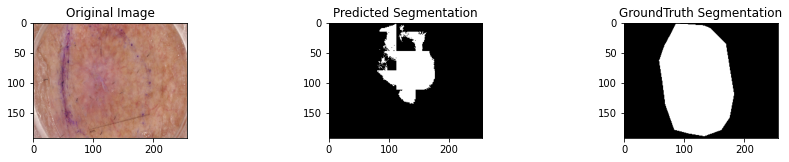

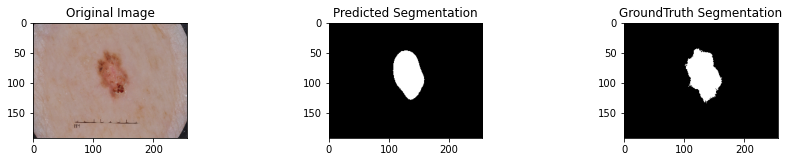

In [ ]:
axes_num = 0
num_images = 10
index_list = np.random.choice(600, 10)
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_test[index_list[i]])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(out[index_list[i]]), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_test[index_list[i]]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

plt.show()

## Results on validation set

In [ ]:
out = FCN_model.predict(X_val * (1./255), batch_size=16)
out.shape

(150, 192, 256, 1)

In [ ]:
out[out < 0.5] = 0
out[out >= 0.5] = 1
iou = IOU(Y_val, out)
print(iou)

tf.Tensor(0.7145398, shape=(), dtype=float32)


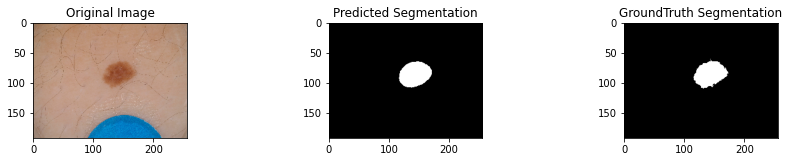

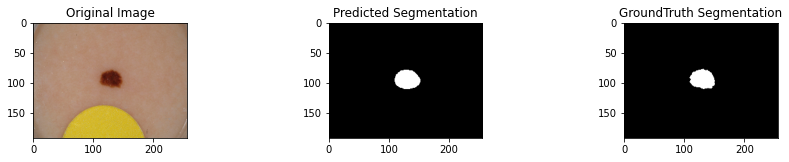

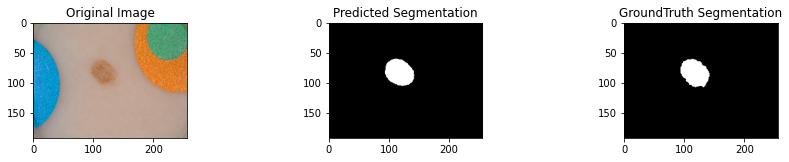

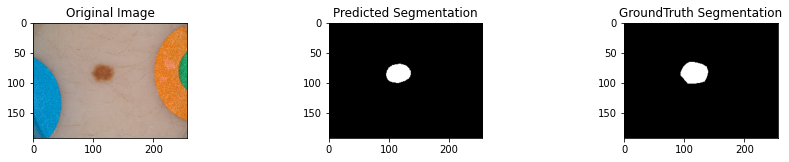

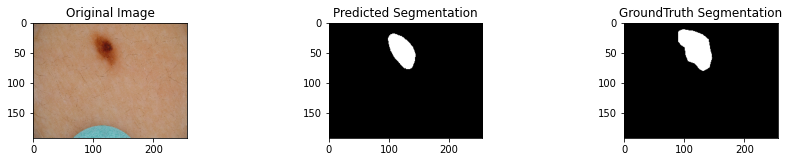

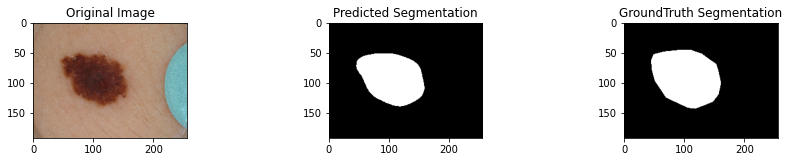

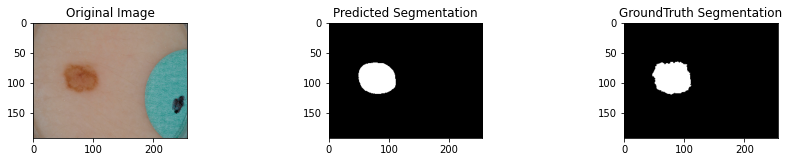

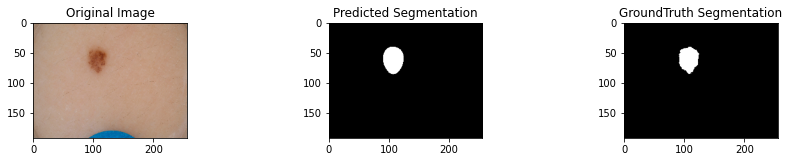

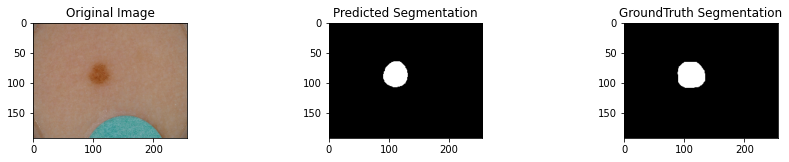

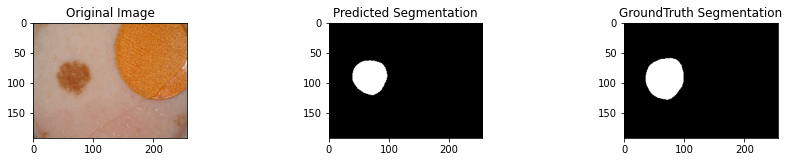

In [ ]:
axes_num = 0
num_images = 10
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_val[i])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(np.squeeze(out[i])), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_val[i]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

    plt.show()

# Unet

## Unet Hyperparameters

In [ ]:
UNET_INP_SHAPE = (192, 256, 3)
UNET_LR = 0.003
BATCH_SIZE = 16
EPOCHS = 50

## Unet blocks


In [ ]:
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(inp)
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    return x

def encoder_block(inp, num_filters):
    x = conv_block(inp, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inp, skip_conn, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same', activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Concatenate()([x, skip_conn])
    x = conv_block(x, num_filters)
    return x

## Define Unet model

In [ ]:
def make_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [ ]:
model = make_unet(UNET_INP_SHAPE)
opt = tf.keras.optimizers.Adam(UNET_LR)
model.compile(loss=jaccard_loss, optimizer=opt, metrics=[IOU])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### Plot Model

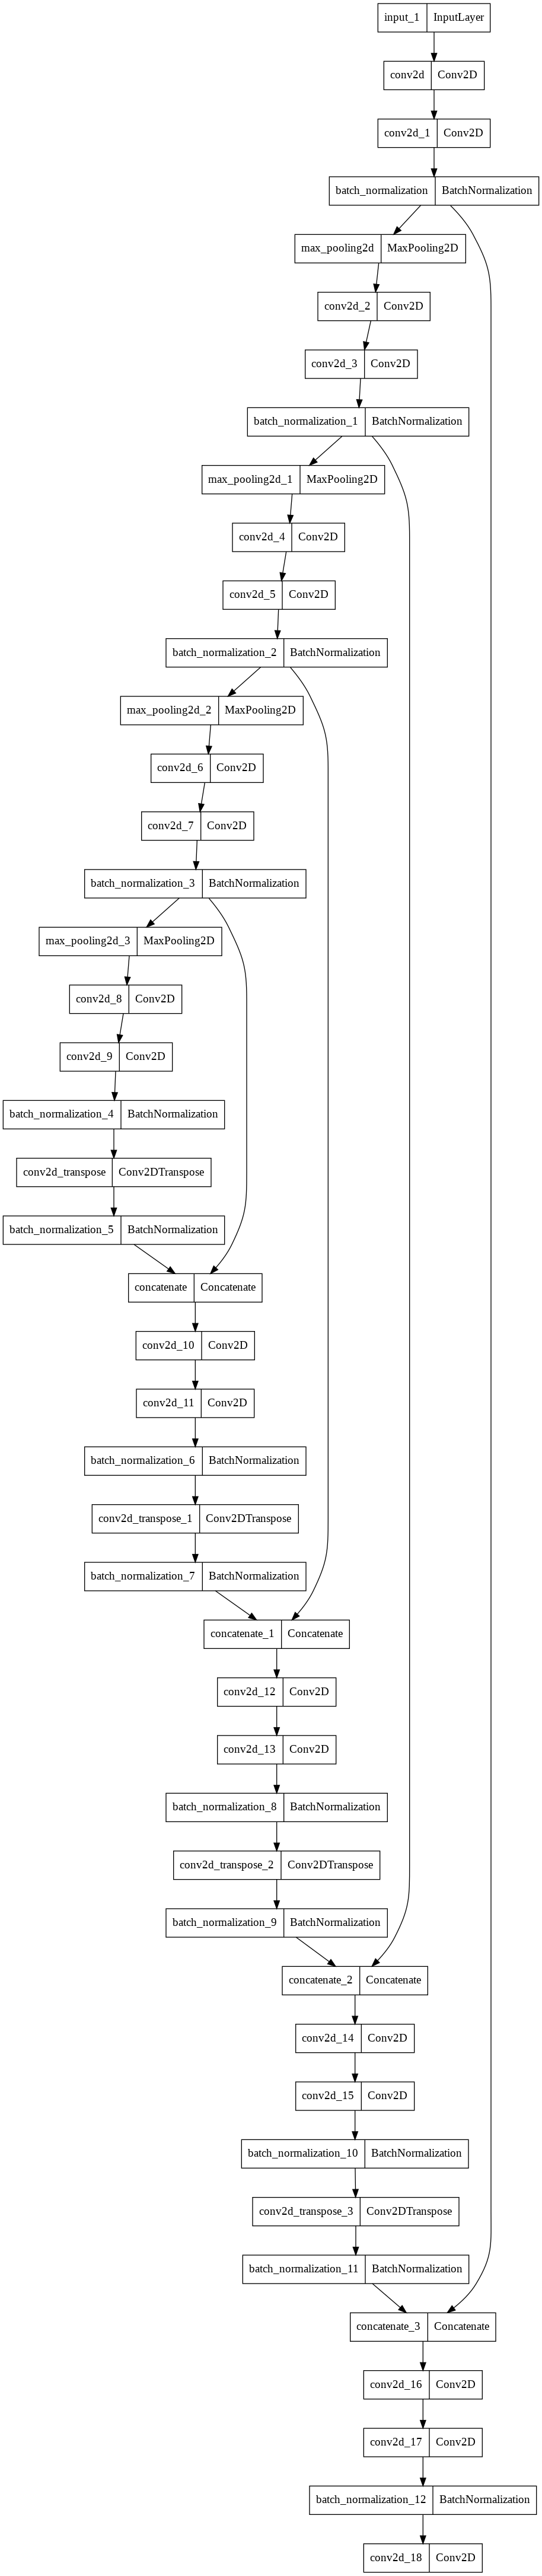

In [ ]:
tf.keras.utils.plot_model(model)

## Train Unet

In [ ]:
steps_per_epoch_train = 2000 // BATCH_SIZE
steps_per_epoch_val = 150 // BATCH_SIZE

In [ ]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, verbose=1,
                                                 min_lr=0.0003)

In [ ]:
history2 = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=20,
                    validation_data=val_generator, 
                    validation_steps=steps_per_epoch_val,
                    callbacks=[lr_reduce])

Epoch 1/20
125/125 [==============================] - 42s 336ms/step - loss: 0.1992 - IOU: 0.8008 - val_loss: 0.3622 - val_IOU: 0.6378
Epoch 2/20
125/125 [==============================] - 42s 336ms/step - loss: 0.1934 - IOU: 0.8066 - val_loss: 0.3305 - val_IOU: 0.6695
Epoch 3/20
125/125 [==============================] - 41s 332ms/step - loss: 0.1824 - IOU: 0.8176 - val_loss: 0.3963 - val_IOU: 0.6037
Epoch 4/20
125/125 [==============================] - 42s 337ms/step - loss: 0.1948 - IOU: 0.8052 - val_loss: 0.3249 - val_IOU: 0.6751
Epoch 5/20
125/125 [==============================] - 42s 333ms/step - loss: 0.1877 - IOU: 0.8123 - val_loss: 0.3470 - val_IOU: 0.6530
Epoch 6/20
125/125 [==============================] - 42s 334ms/step - loss: 0.1900 - IOU: 0.8100 - val_loss: 0.3339 - val_IOU: 0.6661
Epoch 7/20
125/125 [==============================] - 42s 333ms/step - loss: 0.1857 - IOU: 0.8143 - val_loss: 0.3493 - val_IOU: 0.6507
Epoch 8/20
125/125 [==============================] - 4

## Unet Trials

### Model with starting LR = 0.01 for 70 epochs

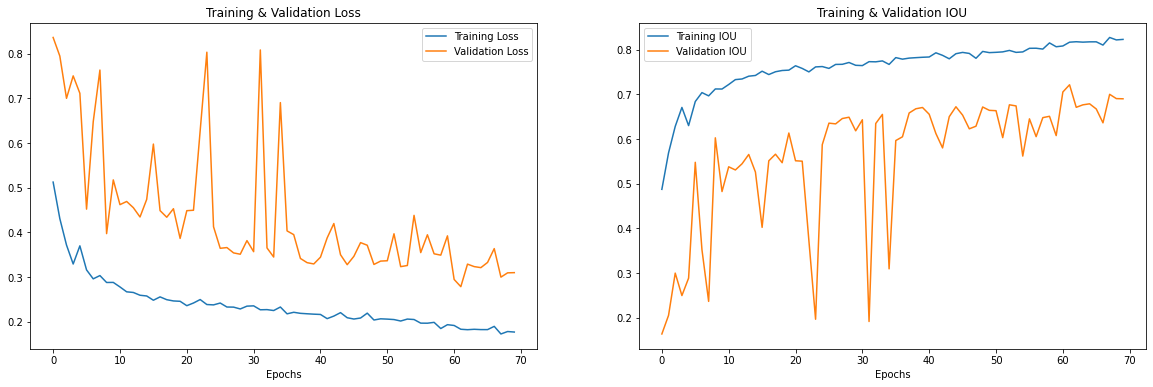

In [ ]:
visualize_loss_and_metric([history, history1])

In [ ]:
out = model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 3s 165ms/step - loss: 0.3172 - IOU: 0.6833
jaccard loss = 0.31722116470336914
IOU = 0.6833325624465942


### Model with starting LR = 0.001 for 70 epochs

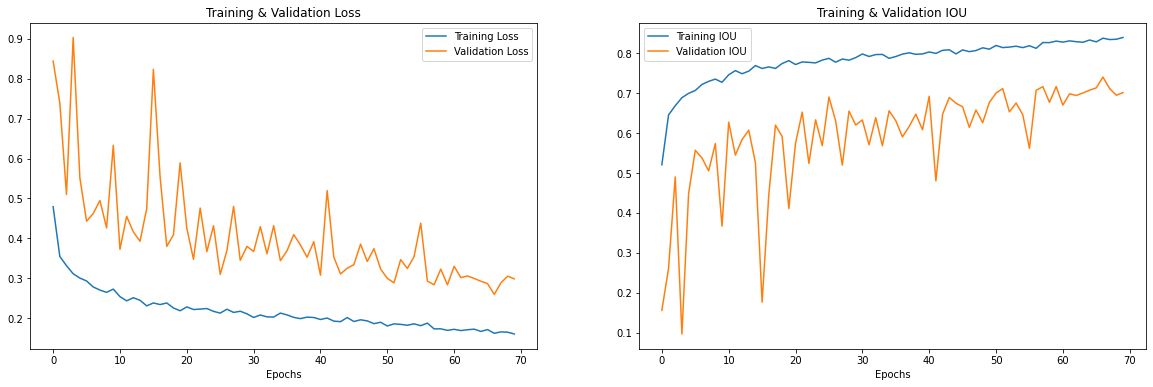

In [ ]:
visualize_loss_and_metric([history1, history2])

In [ ]:
out = model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 3s 166ms/step - loss: 0.3180 - IOU: 0.6825
jaccard loss = 0.3180064260959625
IOU = 0.6825181245803833


### Model with starting LR = 0.003 for 70 epochs

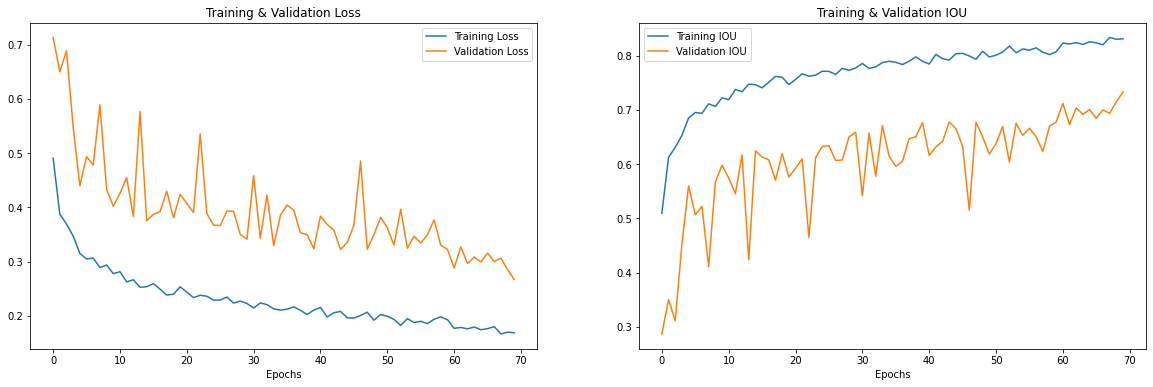

In [ ]:
visualize_loss_and_metric([history, history1])

In [ ]:
out = model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 3s 166ms/step - loss: 0.3080 - IOU: 0.6930
jaccard loss = 0.3079819977283478
IOU = 0.6929685473442078


In [ ]:
out[out < 0.5] = 0
out[out >= 0.5] = 1
iou = IOU(Y_test, out)
print(iou)

tf.Tensor(0.7186657, shape=(), dtype=float32)


## Results on test set for best model

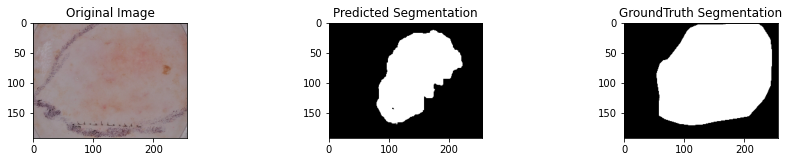

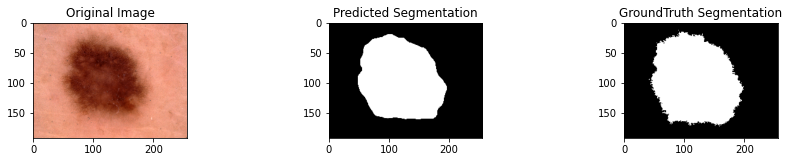

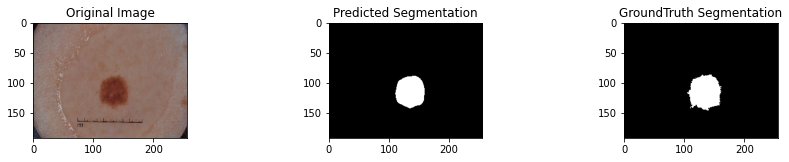

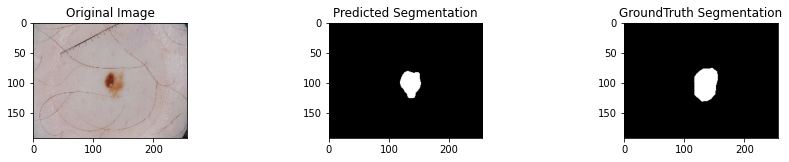

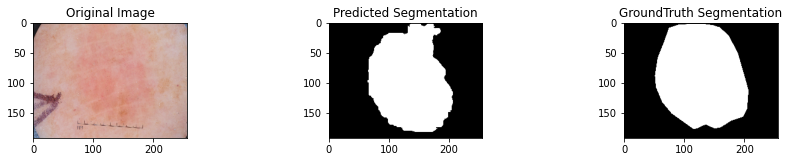

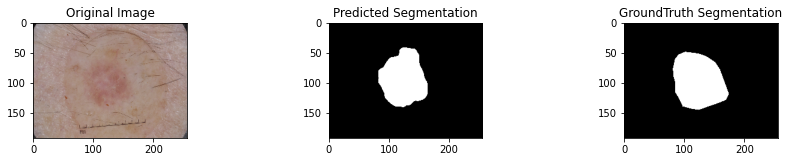

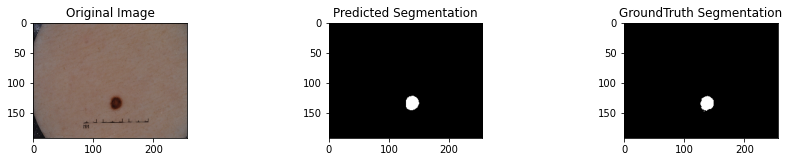

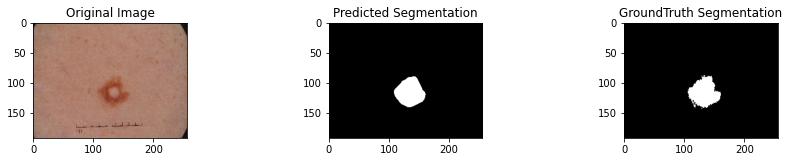

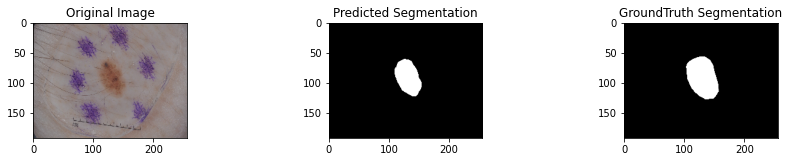

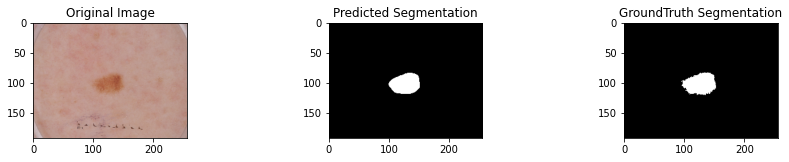

In [ ]:
axes_num = 0
num_images = 10
index_list = np.random.choice(600, num_images)
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_test[index_list[i]])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(out[index_list[i]]), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_test[index_list[i]]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

plt.show()

In [ ]:
model.save_weights('unet_w.h5')

## Resnet V2 as a pretrained encoder for Unet
imagenet weights as an initializer

LR = 0.0003

75 epochs

40 million params

In [ ]:
def build_ResNetV2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    res = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False
                                                     ,input_tensor=inputs)
    
    """ Encoder """
    s1 = res.get_layer("conv1_conv").output
    s2 = res.get_layer("conv2_block2_out").output         
    s3 = res.get_layer("conv3_block3_out").output         
    s4 = res.get_layer("conv4_block5_out").output        

    
    b1 = res.get_layer("post_relu").output         

    
    d1 = decoder_block(b1, s4, 512)                    
    d2 = decoder_block(d1, s3, 256)                    
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                     
    x = Conv2DTranspose(32, (2, 2), strides=2, padding='same', activation='relu')(d4)
 
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs, outputs, name="RES_U-Net")
    return model

In [ ]:
input_shape = (192, 256, 3)
model = build_ResNetV2_unet(input_shape)
opt = tf.keras.optimizers.Adam(0.0003)
# model.load_weights('best/unet_weights.h5')
model.compile(loss=jaccard_loss, optimizer=opt, metrics=[IOU])
model.summary()

Model: "RES_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 128, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 98, 130, 64)  0           conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
steps_per_epoch_train = 2000 // 16
steps_per_epoch_val = 150 // 16

In [ ]:
os.mkdir('best')

In [ ]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00003)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best/unet_weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
history1 = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=75,
                    validation_data=val_generator,
                    validation_steps=steps_per_epoch_val,
                    callbacks=[lr_reduce, model_checkpoint_callback]
                   )

2022-01-21 09:50:31.288223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2022-01-21 09:50:37.613649: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 48s 278ms/step - loss: 0.4056 - IOU: 0.5944 - val_loss: 0.7651 - val_IOU: 0.2349

Epoch 00001: val_loss improved from inf to 0.76513, saving model to ./best/unet_weights.h5
Epoch 2/75
125/125 [==============================] - 34s 274ms/step - loss: 0.2430 - IOU: 0.7570 - val_loss: 0.4007 - val_IOU: 0.5993

Epoch 00002: val_loss improved from 0.76513 to 0.40066, saving model to ./best/unet_weights.h5
Epoch 3/75
125/125 [==============================] - 34s 273ms/step - loss: 0.2332 - IOU: 0.7668 - val_loss: 0.5727 - val_IOU: 0.4273

Epoch 00003: val_loss did not improve from 0.40066
Epoch 4/75
125/125 [==============================] - 34s 273ms/step - loss: 0.2203 - IOU: 0.7797 - val_loss: 0.3913 - val_IOU: 0.6087

Epoch 00004: val_loss improved from 0.40066 to 0.39132, saving model to ./best/unet_weights.h5
Epoch 5/75
125/125 [==============================] - 34s 272ms/step - loss: 0.2087 - IOU: 0.7913 - val_loss: 0.3224 - val_IOU: 0.6776


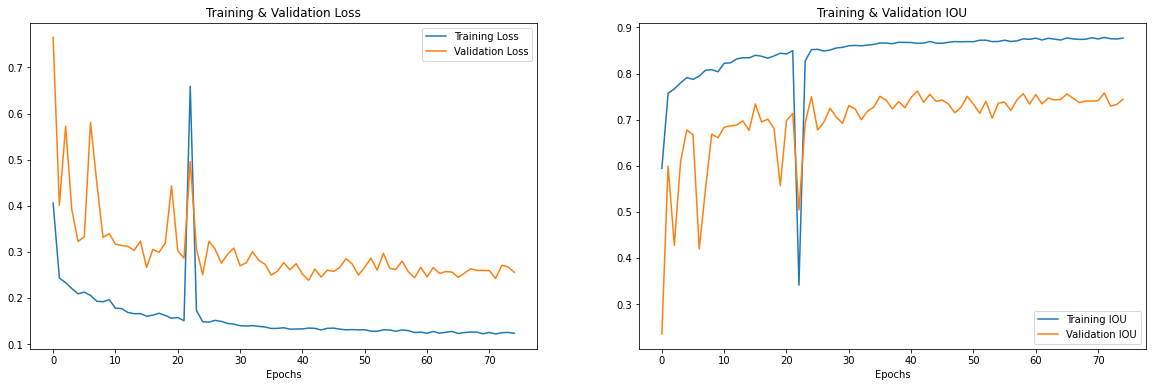

In [ ]:
visualize_loss_and_metric([history1])

In [ ]:
out = model.predict(X_test * (1./255), batch_size=16)
out.shape

(600, 192, 256, 1)

In [ ]:
loss_iou = model.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 3s 95ms/step - loss: 0.2604 - IOU: 0.7396
jaccard loss = 0.26037347316741943
IOU = 0.7396044731140137


In [ ]:
out[out < 0.5] = 0
out[out >= 0.5] = 1
iou = IOU(Y_test, out)
print(iou)

tf.Tensor(0.7631006, shape=(), dtype=float32)


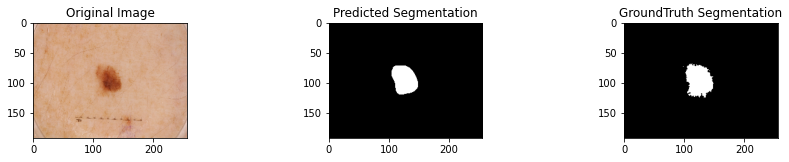

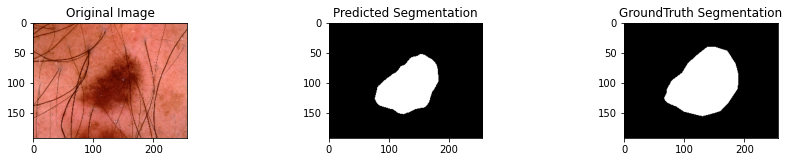

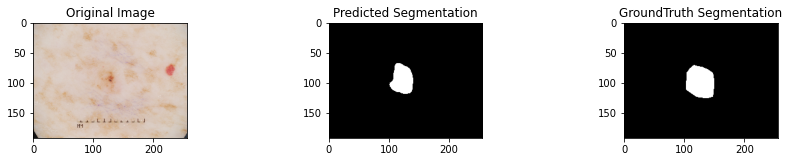

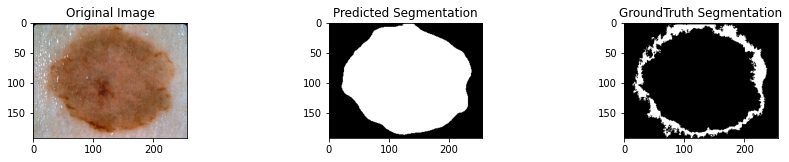

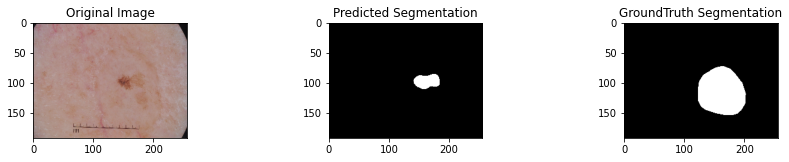

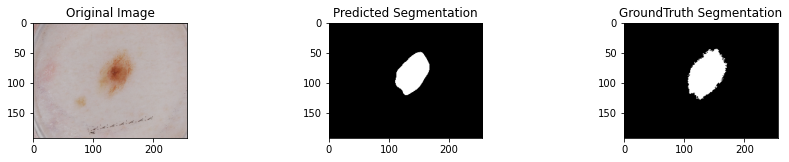

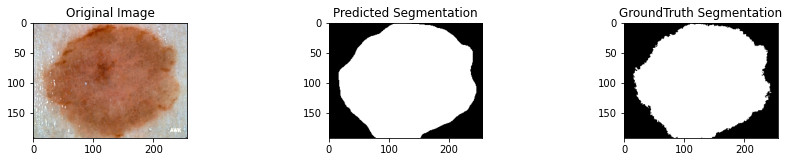

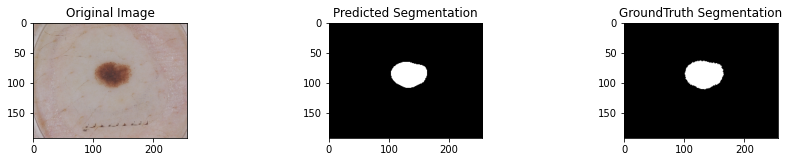

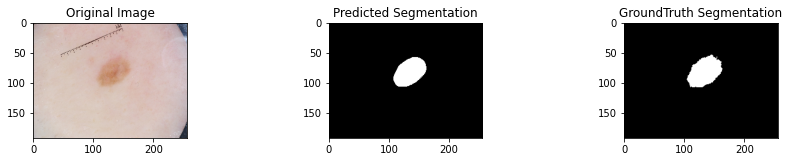

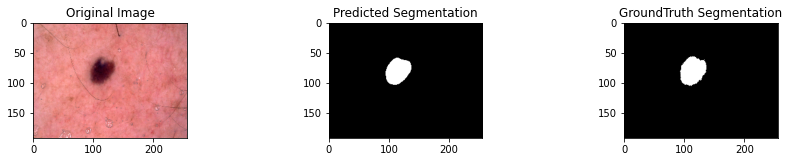

In [ ]:
axes_num = 0
num_images = 10
index_list = np.random.choice(600, num_images)
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_test[index_list[i]])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(out[index_list[i]]), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_test[index_list[i]]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

plt.show()

## Large Unet model 93 million params


Learning Rate starting from 0.0001 with step decay

Batch size = 16

200 epochs



In [ ]:
def step_decay(epoch):
    initial_lrtate=UNET_LR
    lrate=initial_lrtate
    if(epoch>150):
        lrate=initial_lrtate*0.5**4
    elif(epoch>100):
        lrate= initial_lrtate*0.5**3
    elif(epoch>70):
        lrate= initial_lrtate*0.5**2
    elif(epoch>50):
        lrate= initial_lrtate*0.5
    return lrate
schedule=tf.keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
model = make_unet(UNET_INP_SHAPE)
opt = tf.keras.optimizers.Adam(UNET_LR)
model.compile(loss=jaccard_loss, optimizer=opt, metrics=[IOU])

model.summary()

2022-01-10 12:46:31.255892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 12:46:31.256820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 12:46:31.257535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 12:46:31.258460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 12:46:31.259104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./',
    save_weights_only=False,
    monitor='val_IOU',
    mode='max',
    save_best_only=True
)

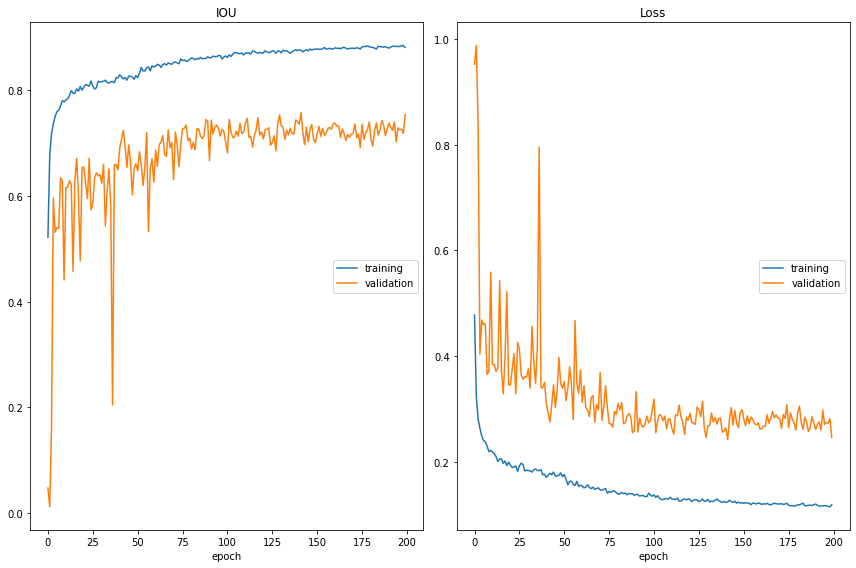

IOU
	training         	 (min:    0.522, max:    0.885, cur:    0.882)
	validation       	 (min:    0.012, max:    0.758, cur:    0.754)
Loss
	training         	 (min:    0.115, max:    0.478, cur:    0.118)
	validation       	 (min:    0.242, max:    0.988, cur:    0.246)


In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=EPOCHS,
                    validation_data=val_generator, 
                    validation_steps=steps_per_epoch_val,callbacks=[PlotLossesKeras(),schedule,model_checkpoint_callback])

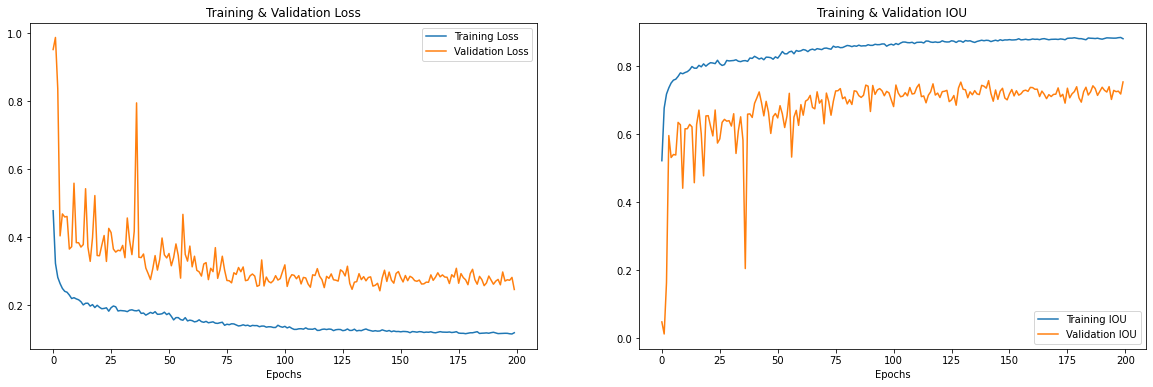

In [ ]:
visualize_loss_and_metric([history])

Take the best model from training and test on it

In [ ]:
model2 =  make_unet(UNET_INP_SHAPE)
model2=tf.keras.models.load_model('./',{'IOU':IOU,"jaccard_loss":jaccard_loss})
out = model2.predict(X_test * (1./255), batch_size=32)
out.shape
loss_iou = model2.evaluate(X_test * (1./255), Y_test)
print(f'jaccard loss = {loss_iou[0]}')
print(f'IOU = {loss_iou[1]}')

19/19 [==============================] - 3s 153ms/step - loss: 0.2847 - IOU: 0.7154
jaccard loss = 0.28466615080833435
IOU = 0.7154307961463928


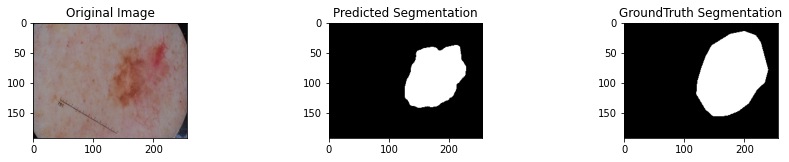

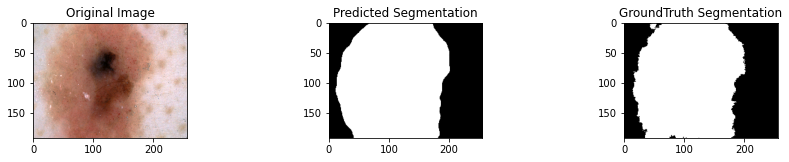

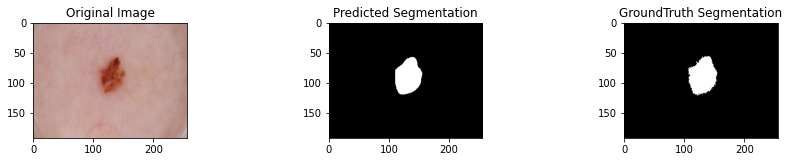

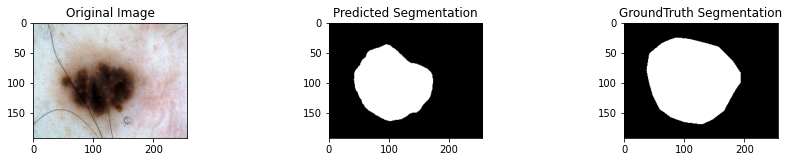

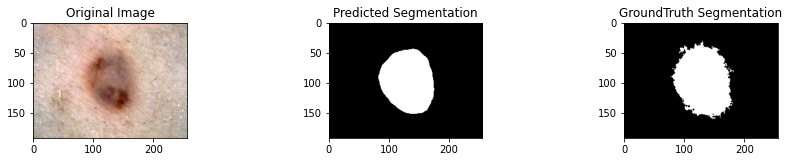

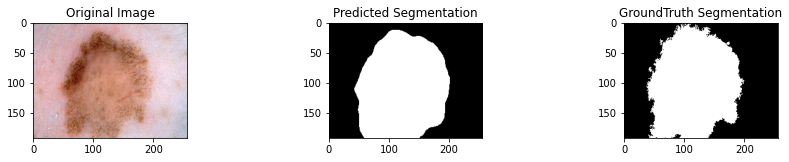

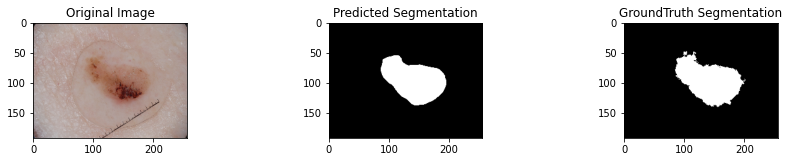

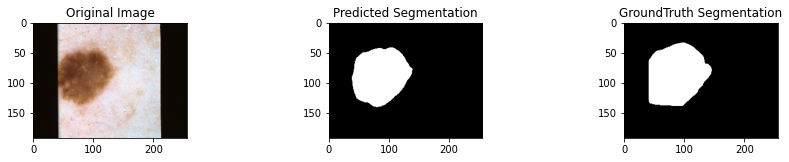

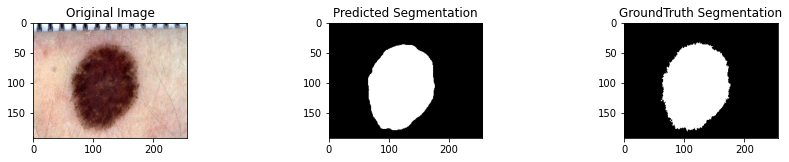

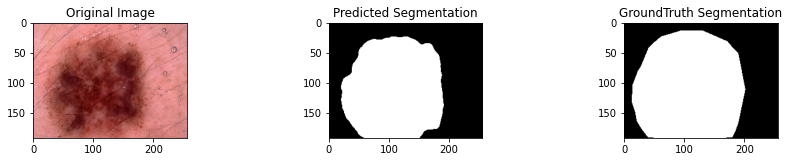

In [ ]:
axes_num = 0
num_images = 10
index_list = np.random.choice(600, 10)
for i in range(num_images):
    plt.figure(figsize=(15,25))
    plt.subplot(num_images, 3, axes_num+1)
    plt.imshow(X_test[index_list[i]])
    plt.title('Original Image')

    plt.subplot(num_images, 3, axes_num+2)
    plt.imshow(np.squeeze(out[index_list[i]]), cmap='gray')
    plt.title('Predicted Segmentation')
    
    plt.subplot(num_images, 3, axes_num+3)
    plt.imshow(np.squeeze(Y_test[index_list[i]]), cmap='gray')
    plt.title('GroundTruth Segmentation')
    axes_num += 3

plt.show()

In [ ]:
def make_unet_large(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)

    b1 = conv_block(p5, 2048)

    d1 = decoder_block(b1, s5, 512)
    d2 = decoder_block(d1, s4, 256)
    d3 = decoder_block(d2, s3, 128)
    d4 = decoder_block(d3, s2, 64)
    d5 = decoder_block(d4, s1, 64)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d5)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model
